In [1]:
!pip install yfinance
import pandas as pd
import numpy as np
import yfinance as yf
from pandas_datareader import data as pdr
yf.pdr_override()
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

import cufflinks as cf
cf.set_config_file(offline=True)


     |████████████████████████████████| 6.3 MB 7.6 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [2]:
# To upload Open and Close prices of(AAPL,MSFT,AMZN,GOOGL,HE)from yahoo
df1 = pdr.get_data_yahoo('AAPL',start='2011-01-01',end='2021-10-31')
df1 = df1[['Open','Close']]
df1 = df1.rename(columns ={'Open': 'Open_AAPL', 'Close':'Close_AAPL'})
df2 = pdr.get_data_yahoo('MSFT','2010-11-01','2021-10-31')
df2 = df2[['Open','Close']]
df2 = df2.rename(columns ={'Open': 'Open_MSFT', 'Close':'Close_MSFT'})
df3 = pdr.get_data_yahoo('AMZN','2010-11-01','2021-10-31')
df3 = df3[['Open','Close']]
df3 = df3.rename(columns ={'Open':'Open_AMZN','Close':'Close_AMZN'})
df4 = pdr.get_data_yahoo('GOOGL','2010-11-01','2021-10-31')
df4 = df4[['Open','Close']]
df4 = df4.rename(columns ={'Open': 'Open_GOOGL', 'Close':'Close_GOOGL'})
df5 =  pdr.get_data_yahoo('HE','2010-11-01','2021-10-31')
df5 = df5[['Open','Close']]
df5 = df5.rename(columns ={'Open': 'Open_HE', 'Close':'Close_HE'})
# To merge stocks in one table
df = df1.merge(df2, on = 'Date')
df = df.merge(df3, on = 'Date')
df = df.merge(df4, on = 'Date')
df = df.merge(df5, on = 'Date')
# To show
df

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Open_AAPL,Close_AAPL,Open_MSFT,Close_MSFT,Open_AMZN,Close_AMZN,Open_GOOGL,Close_GOOGL,Open_HE,Close_HE
Date,,,,,,,,,,
2011-01-03,11.630000,11.770357,28.049999,27.980000,181.369995,184.220001,298.538544,302.477478,22.900000,22.920000
2011-01-04,11.872857,11.831786,27.940001,28.090000,186.149994,185.009995,303.113098,301.361359,23.270000,23.850000
2011-01-05,11.769643,11.928571,27.900000,28.000000,184.100006,187.419998,300.335327,304.839844,23.850000,23.809999
2011-01-06,11.954286,11.918929,28.040001,28.820000,186.500000,185.860001,305.645660,307.057068,23.790001,23.870001
2011-01-07,11.928214,12.004286,28.639999,28.600000,187.880005,185.490005,308.263275,308.528534,23.870001,24.760000
...,...,...,...,...,...,...,...,...,...,...
2021-10-25,148.679993,148.639999,309.359985,308.130005,3335.000000,3320.370117,2751.000000,2748.939941,41.459999,40.990002
2021-10-26,149.330002,149.320007,311.000000,310.109985,3349.510010,3376.070068,2785.270020,2786.169922,41.099998,40.669998
2021-10-27,149.360001,148.850006,316.000000,323.170013,3388.000000,3392.489990,2788.100098,2924.350098,40.880001,40.680000


In [3]:
# To select first three years of daily price data
three_years = df.loc['2011-01-01': '2013-12-31']
three_years = three_years[['Close_AAPL','Close_MSFT','Close_AMZN','Close_GOOGL','Close_HE']]
# To convert Close Prices  into daily return values.
three_years['Return_AAPL']= three_years['Close_AAPL'].pct_change()
three_years['Return_MSFT']= three_years['Close_MSFT'].pct_change()
three_years['Return_AMZN']= three_years['Close_AMZN'].pct_change()
three_years['Return_GOOGL']= three_years['Close_GOOGL'].pct_change()
three_years['Return_HE']= three_years['Close_HE'].pct_change()
three_years = three_years[['Return_AAPL','Return_MSFT','Return_AMZN','Return_GOOGL','Return_HE']]
# To remove missing values
three_years= three_years.dropna()
three_years



,Return_AAPL,Return_MSFT,Return_AMZN,Return_GOOGL,Return_HE
Date,,,,,
2011-01-04,0.005219,0.003931,0.004288,-0.003690,0.040576
2011-01-05,0.008180,-0.003204,0.013026,0.011543,-0.001677
2011-01-06,-0.000808,0.029286,-0.008324,0.007273,0.002520
2011-01-07,0.007161,-0.007634,-0.001991,0.004792,0.037285
2011-01-10,0.018833,-0.013287,-0.004367,-0.003618,-0.014136
...,...,...,...,...,...
2013-12-24,-0.004245,0.012562,-0.009233,-0.002923,0.002306
2013-12-26,-0.006641,0.009709,0.013001,0.005055,-0.008052
2013-12-27,-0.006757,-0.004006,-0.015604,0.000841,0.003092


In [4]:
# To generate at least ten thousand (10,000) different no_of_portfolios 
matrix_of_return_value = np.asmatrix(three_years)
matrix_of_return_value = matrix_of_return_value.T

no_of_asset_classes = 5
no_of_portfolios = 10000
np.random.seed(123)

# To Initial list
collection_of_random_asset_weights = []
portfolio_means = []
portfolio_standard_deviations = []
portfolio_sharpe_ratios = []

def get_random_asset_weights(no_of_asset_classes):
    random_asset_weights = np.random.rand(no_of_asset_classes)
    random_asset_weights /= sum(random_asset_weights)
    random_asset_weights = np.asmatrix(random_asset_weights)
    return random_asset_weights

# To creat statistics of portfolio
def get_portfolio_statistics(asset_weights, matrix_of_return_value):
    asset_means = np.asmatrix(np.mean(matrix_of_return_value, axis = 1))
    asset_covariances = np.asmatrix(np.cov(matrix_of_return_value))
    portfolio_mean= asset_weights * asset_means
    portfolio_mean= portfolio_mean.item()
    portfolio_standard_deviation= np.sqrt(asset_weights * asset_covariances * asset_weights.T)
    portfolio_standard_deviation= portfolio_standard_deviation.item()
    portfolio_sharpe_ratio= portfolio_mean / portfolio_standard_deviation
    return portfolio_mean, portfolio_standard_deviation, portfolio_sharpe_ratio

while len(collection_of_random_asset_weights) < no_of_portfolios:
    random_asset_weights = get_random_asset_weights(no_of_asset_classes)
    collection_of_random_asset_weights.append(random_asset_weights)
    portfolio_means.append(get_portfolio_statistics(random_asset_weights, matrix_of_return_value)[0])
    portfolio_standard_deviations.append(get_portfolio_statistics(random_asset_weights, matrix_of_return_value)[1])
    portfolio_sharpe_ratios.append(get_portfolio_statistics(random_asset_weights, matrix_of_return_value)[2])
    

# To find the maximum value of Sharpe ratio     
index = portfolio_sharpe_ratios.index(max(portfolio_sharpe_ratios))
print(collection_of_random_asset_weights[index]) 
print(portfolio_sharpe_ratios[index])
 

[[0.25910001 0.05602275 0.3305976  0.34833791 0.00594174]]
0.07405983004123953


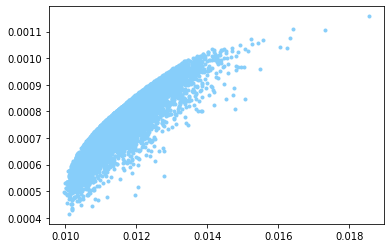

In [5]:
plt.plot(portfolio_standard_deviations,portfolio_means, 'o', markersize = 3, color = 'lightskyblue') 
plt.show()

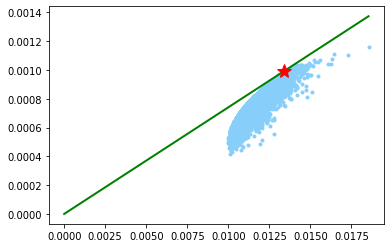

In [6]:
x = np.linspace(0, max(portfolio_standard_deviations), 10000)
y = portfolio_sharpe_ratios[index] * x
plt.plot( portfolio_standard_deviations,portfolio_means, 'o', markersize = 3, color = 'lightskyblue')
plt.plot(x, y, '-', linewidth = 2, color = 'green')
plt.plot(portfolio_standard_deviations[index],portfolio_means[index],color="red",marker="*",markersize = 15)
plt.show()

In [7]:
# To Create a Pandas DataFrame with a single row containing these asset weights, used max of portfolio_sharpe_ratios
some_wights= pd.DataFrame({'AAPL': [0.25910001], 'MSFT': [0.05602275], 'AMZN':[0.3305976], 'GOOGL':[0.34833791], 'HE':[0.00594174] }, index = [three_years.last_valid_index()])
some_wights

,AAPL,MSFT,AMZN,GOOGL,HE
2013-12-31,0.2591,0.056023,0.330598,0.348338,0.005942


In [8]:
capital = 10000
allocations = capital*some_wights
allocations

,AAPL,MSFT,AMZN,GOOGL,HE
2013-12-31,2591.0001,560.2275,3305.976,3483.3791,59.4174


In [9]:
print(df['Close_AAPL'].loc[some_wights.last_valid_index()])
print(df['Close_MSFT'].loc[some_wights.last_valid_index()])
print(df['Close_AMZN'].loc[some_wights.last_valid_index()])
print(df['Close_GOOGL'].loc[some_wights.last_valid_index()])
print(df['Close_HE'].loc[some_wights.last_valid_index()])



no_of_shares = allocations /df[[f'Open_{sym}' for sym in some_wights.columns]].loc[some_wights.index[0]].values
no_of_shares

20.036428451538086
37.40999984741211
398.7900085449219
560.9158935546875
26.059999465942383


,AAPL,MSFT,AMZN,GOOGL,HE
2013-12-31,130.912899,14.979344,8.378469,6.257454,2.280898


In [10]:
# Convert optimized portfolio into investable fund
seven_years = df.loc['2013-12-31':] 
seven_years['Open'] = seven_years['Open_AAPL']*no_of_shares['AAPL'].iloc[0] + seven_years['Open_MSFT']*no_of_shares['MSFT'].iloc[0] + seven_years['Open_AMZN']*no_of_shares['AMZN'].iloc[0]+ seven_years['Open_GOOGL']*no_of_shares['GOOGL'].iloc[0]+ seven_years['Open_HE']*no_of_shares['HE'].iloc[0]
seven_years['Close'] = seven_years['Close_AAPL']*no_of_shares['AAPL'].iloc[0] + seven_years['Close_MSFT']*no_of_shares['MSFT'].iloc[0]+ seven_years['Close_AMZN']*no_of_shares['AMZN'].iloc[0]+ seven_years['Close_GOOGL']*no_of_shares['GOOGL'].iloc[0]+ seven_years['Close_HE']*no_of_shares['HE'].iloc[0]
seven_years = seven_years[['Open','Close']]
seven_years

,Open,Close
Date,,
2013-12-31,10000.000100,10093.999622
2014-01-02,10051.706880,10021.469859
2014-01-03,10029.375753,9922.873707
2014-01-06,9925.613561,9939.635803
2014-01-07,9980.344171,10030.606590
...,...,...
2021-10-25,69349.154461,69188.955771
2021-10-26,69794.009011,70006.551691
2021-10-27,70212.527425,71142.905901


[*********************100%***********************]  1 of 1 completed
Absolute Return of Our Portfolio:614.54%
CAGR of Our Portfolio: 19.92%
Information Ratio of Our Portfolio:3.52



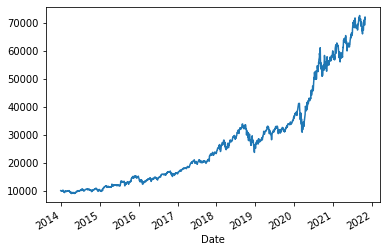

In [14]:
#absolute_return = (seven_years['Close'].iloc[-1]-capital)/capital
#CAGR = ((seven_years['Close'].iloc[-1]-capital)**(365/(df.index[-1] - df.index[0]).days))-1
#information_ratio = (seven_years.Close.pct_change().mean()/seven_years.Close.pct_change().std())*((252) **0.5)

#s=f"""Abslute Return of Our Portofolio:{absolute_return*100:.2f}%
#CAGR of Our Portofolio: {CAGR*100:.2f}%
#Information Ratio of Our Portofolio:{information_ratio:.2f}
#"""
#print(s)
#seven_years.Close.plot()


# To calculate Absolute Return, Compound Annual Growth Rate, and Information Ratio of fund
absolute_return_SFA = (seven_years['Close'].iloc[-1]-capital)/capital
CAGR_SFA = ((seven_years['Close'].iloc[-1]/capital)**(365/(df.index[-1] - df.index[0]).days))-1

# choosing S&P500 to be benchmark
df_SP500 = pdr.get_data_yahoo('^GSPC', '2014-01-01', '2021-10-30')
df_SP500 = df_SP500[['Open', 'Close']]
df_SP500 = df_SP500.rename(columns = {'Open': 'Open_SP500', 'Close': 'Close_SP500'})

# calculate information_ratio_SFA
information_ratio_SFA = (seven_years.Close.pct_change().dropna().mean() - df_SP500.Close_SP500.pct_change().dropna().mean())/(seven_years.Close.pct_change().dropna().std()*df_SP500.Close_SP500.pct_change().dropna().std())

SFA=f"""Absolute Return of Our Portfolio:{absolute_return_SFA*100:.2f}%
CAGR of Our Portfolio: {CAGR_SFA*100:.2f}%
Information Ratio of Our Portfolio:{information_ratio_SFA:.2f}
"""
print(SFA)
seven_years.Close.plot()


In [15]:
# generate predictive features
short_time = 5
long_time = 15
seven_years['Close_Short_Rolling']= seven_years['Close'].rolling(window = short_time).mean()
seven_years['Close_Long_Rolling']= seven_years['Close'].rolling(window = long_time).mean()
seven_years['Window_diff']=seven_years['Close_Long_Rolling'] - seven_years['Close_Short_Rolling']
seven_years['Open_1_change'] = seven_years['Open']-seven_years['Open'].shift(1)
seven_years = seven_years.dropna()
seven_years

,Open,Close,Close_Short_Rolling,Close_Long_Rolling,Window_diff,Open_1_change
Date,,,,,,
2014-01-22,10251.882595,10215.661388,10159.277909,10053.731445,-105.546464,98.244036
2014-01-23,10165.244487,10184.929430,10170.203553,10059.793432,-110.410121,-86.638107
2014-01-24,10152.625466,9931.176067,10128.181110,10053.773846,-74.407265,-12.619021
2014-01-27,9982.183216,9858.045056,10082.906645,10049.451936,-33.454709,-170.442249
2014-01-28,9702.228988,9792.393933,9996.441175,10039.635811,43.194636,-279.954228
...,...,...,...,...,...,...
2021-10-25,69349.154461,69188.955771,70192.625653,68943.391823,-1249.233830,-1068.406322
2021-10-26,69794.009011,70006.551691,70000.176702,69150.243363,-849.933339,444.854550
2021-10-27,70212.527425,71142.905901,70109.616302,69385.001723,-724.614578,418.518414


In [16]:
# split your data 0.3 to train data and  the remainder for the test 
X = seven_years.copy()
y = np.where(X.Close.shift(-1) >= X.Close, 1,-1)
index = int(0.3*len(X))
X_train = X.iloc[:index]
X_test = X.iloc[index:]
y_train = y[:index]
y_test = y[index:]
logistic = LogisticRegression()
logistic = logistic.fit(X_train,y_train)
pd.DataFrame(zip(X.columns, np.transpose(logistic.coef_)))

,0,1
0,Open,[-0.00048562833849920945]
1,Close,[-0.00035399280762953304]
2,Close_Short_Rolling,[0.00043154077367057336]
3,Close_Long_Rolling,[0.0004180718194312686]
4,Window_diff,[-1.3468954239088199e-05]
5,Open_1_change,[0.0012619911234773083]


In [17]:
# creat predictions using your X_test data and metrics confusion
predictions = logistic.predict(X_test)
print(metrics.confusion_matrix(y_test,predictions))
print(logistic.score(X_test,y_test))

[[181 397]
 [225 569]]
0.5466472303206997


In [18]:
# To run a classification report
results = X_test.copy()
results['C2C_Price']= X_test.Close.shift(-1) - X_test.Close
results['Predictions'] = predictions
results['True_Label']= y_test
results['Return']= results['C2C_Price']*results['Predictions']
results['Cum_Return']= results['Return'].cumsum()
results = results.dropna()
results

,Open,Close,Close_Short_Rolling,Close_Long_Rolling,Window_diff,Open_1_change,C2C_Price,Predictions,True_Label,Return,Cum_Return
Date,,,,,,,,,,,
2016-05-20,14283.942632,14352.764203,14310.669236,14210.618209,-100.051027,65.421060,-47.583810,1,-1,-47.583810,-47.583810
2016-05-23,14375.061231,14305.180393,14281.893912,14224.454366,-57.439546,91.118600,233.644428,1,1,233.644428,186.060618
2016-05-24,14367.966516,14538.824821,14345.024320,14260.836992,-84.187328,-7.094715,130.316354,1,1,130.316354,316.376972
2016-05-25,14612.677506,14669.141175,14420.932510,14306.925994,-114.006516,244.710990,69.732379,1,1,69.732379,386.109351
2016-05-26,14654.152700,14738.873554,14520.956829,14364.892833,-156.063996,41.475194,49.010681,-1,1,-49.010681,337.098670
...,...,...,...,...,...,...,...,...,...,...,...
2021-10-22,70417.560783,69354.439809,70480.638248,68731.093029,-1749.545219,-108.740726,-165.484038,1,-1,-165.484038,27685.387290
2021-10-25,69349.154461,69188.955771,70192.625653,68943.391823,-1249.233830,-1068.406322,817.595920,-1,1,-817.595920,26867.791370
2021-10-26,69794.009011,70006.551691,70000.176702,69150.243363,-849.933339,444.854550,1136.354210,1,1,1136.354210,28004.145580


Abslute Return of Our Algorithmic Trading:620.55%
Abslute Return of Our buy-and-hold Trading :404.44%
CAGR of Our Algorithmic Trading: 177.11%
CAGR of Our buy-and-hold Trading: 16.14%
Information Ratio of Our Algorithmic Trading:4.53
Information Ratio of Our buy-and-hold Trading:4.53



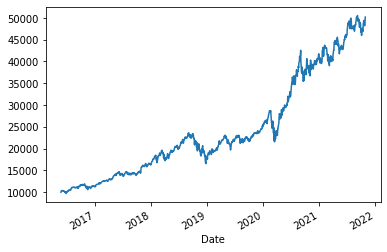

In [27]:
absolute_return_tf = (results['Close'].iloc[-1]-capital)/capital
CAGR_tf = ((results['Close'].iloc[-1]-capital)**(365/(df.index[-1] - df.index[0]).days))-1
#information_ratio_tf = (results.Close.pct_change().mean()/results.Close.pct_change().std())*((252) **0.5)
information_ratio_tf = (results.Close.pct_change().mean() - df_SP500.Close_SP500.pct_change().dropna().mean())/(results.Close.pct_change().std()*df_SP500.Close_SP500.pct_change().dropna().std())

absolute_return_bh = (results.Close.iloc[-1]-results.Open.iloc[0])/results.Open.iloc[0]
CAGR_bh = ((results.Close.iloc[-1]/results.Open.iloc[0])**(252/len(df)))-1
#information_ratio_bh = (results.Close.pct_change().mean()/results.Close.pct_change().std())*((252) **0.5)
information_ratio_bh = (results.Close.pct_change().mean() - df_SP500.Close_SP500.pct_change().dropna().mean())/(results.Close.pct_change().std()*df_SP500.Close_SP500.pct_change().dropna().std())

s=f"""Abslute Return of Our Algorithmic Trading:{absolute_return_tf*100:.2f}%
Abslute Return of Our buy-and-hold Trading :{absolute_return_bh*100:.2f}%
CAGR of Our Algorithmic Trading: {CAGR_tf*100:.2f}%
CAGR of Our buy-and-hold Trading: {CAGR_bh*100:.2f}%
Information Ratio of Our Algorithmic Trading:{information_ratio_tf:.2f}
Information Ratio of Our buy-and-hold Trading:{information_ratio_bh:.2f}
"""

print(s)
results.Close.iplot()

((results.Close.pct_change().dropna()+1).cumprod()*capital).plot()
